# In Painting FashionMNIST

## Imports

In [ ]:
import torch
from torch import nn
import torchvision.utils as vutils
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

dataset_path = "../data" 

# Set random seeds for reproducibility
torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Hyperparameters 

In [316]:
batch_size = 64
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMGS_TO_VISUALIZE = 4
d = 20
lr = 0.0002
beta1 = 0.5
num_epochs = 50

## Loading Data

In [317]:
transform = transforms.Compose([transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(
    CIFAR10(dataset_path, train=True, download=True,
                   transform=transform),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    CIFAR10(dataset_path, train=False, transform=transform),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


### Helpers

In [318]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

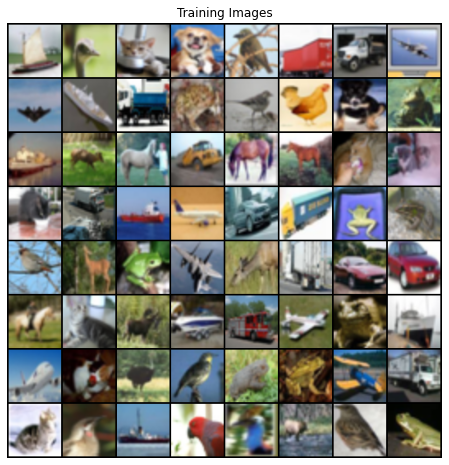

In [319]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Mask function

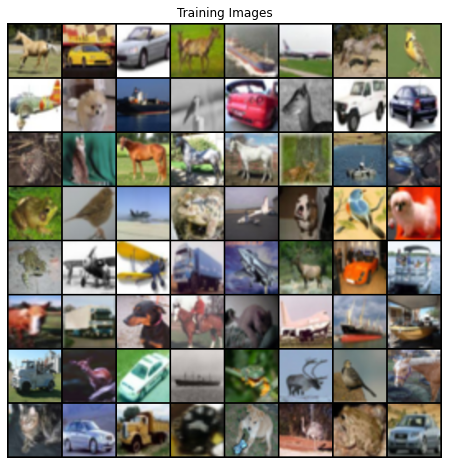

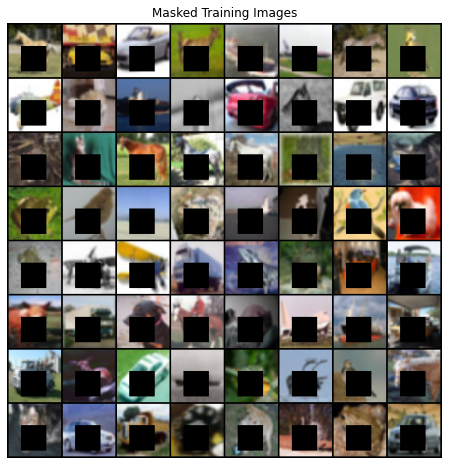

In [320]:
def mask_img_batch(img_batch):
    b_size = img_batch.shape[0]
    im_size = img_batch.shape[2]
    p_mask = np.random.uniform(0.3, 0.5)
    mask_size = int(im_size*p_mask)
    x = np.random.randint(int(im_size/2))
    y = np.random.randint(int(im_size/2))
    mask = torch.zeros((b_size, 3, mask_size, mask_size))
    mask.fill_(-1)

    masked_batch = img_batch.clone()
    masked_batch[:, :, x:mask_size+x, y:mask_size+y] = mask
    return masked_batch


real_batch = next(iter(train_loader))
masked_batch = mask_img_batch(real_batch[0])

# Plot some training images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot some masked training images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Masked Training Images")
plt.imshow(np.transpose(vutils.make_grid(masked_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [321]:
torch.min(real_batch[0][0])

tensor(-0.9843)

## Define GAN

### GENERATOR

In [341]:
def make_conv_block(_in, out, batch_norm=True):
    kernel = (4,4)
    stride=2
    pad = 1
    layers = []
    layers.append(nn.Conv2d(_in, out, kernel_size=kernel, stride=stride, padding=pad))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out))
    layers.append(nn.LeakyReLU(0.2,inplace=True))
    return nn.Sequential(*layers)

def make_decov_block(_in, out, batch_norm=True):
    kernel = (4,4)
    stride=2
    pad = 1
    layers = []
    layers.append(nn.ConvTranspose2d(_in, out, kernel_size=kernel, stride=stride, padding=pad))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
         super(Generator, self).__init__()

         # encoder:
         self.encoder = nn.Sequential(
             make_conv_block(3, 64, batch_norm=False),
             make_conv_block(64, 128),
             make_conv_block(128, 256),
             make_conv_block(256, 512)
         )

         self.decoder = nn.Sequential(
             make_decov_block(512, 256),
             make_decov_block(256, 128),
             make_decov_block(128, 64),
             nn.ConvTranspose2d(64, 3, kernel_size=(4,4), stride=2, padding=1),
             nn.Tanh()

         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
G = Generator().to(device)
G

Generator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (decoder): Sequential(
    (0): Sequential

### Discriminator 

In [323]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = make_conv_block(3, 64, batch_norm=False)
        self.conv2 = make_conv_block(64, 128)
        self.conv3 = make_conv_block(128, 256)
        self.conv4 = make_conv_block(256, 512)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=(4,4), stride=1, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.conv5(x)

D = Discriminator().to(device)
D

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): 

### Init weights

In [324]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): 

## Training 

### Setup

In [325]:
# Initialize Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

# test images 
test_batch = next(iter(test_loader))
masked_batch = mask_img_batch(test_batch[0]).to(device)

### Training Loop

In [356]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print_every =1000

## FOR TESTING !!
num_epochs = 100


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (true_imgs, _) in enumerate(train_loader, 0):
        masked_imgs = mask_img_batch(true_imgs)

        true_imgs = true_imgs.to(device)
        masked_imgs = masked_imgs.to(device)

        b_size = true_imgs.size(0)
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # (1) Update D network

        D.zero_grad()
        output = D(true_imgs).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, labels)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()


        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = G(masked_imgs)
        labels.fill_(fake_label)

        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (2) Update G network
        G.zero_grad()
        labels.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, labels)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == print_every:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # save test images every epoch
    fake = G(masked_batch.to(device)).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))




Starting Training Loop...


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())